# Bayesian Network Classifier
### Autor: [Campardo Giorgia](giorgia.campardo@stud.unibo.it)
### Project for module 3 of Fundamental of AI at University of Bologna

In this notebook I illustrate the implementation of several Bayesian network classifiers. 

Starting from the analysis of this [dataset](https://www.kaggle.com/namanmanchanda/entrepreneurial-competency-in-university-students) about entrepreneurial competency in university students, I extract the most important features that can predict whether the student will become an entrepreneur or not and use them in order to define two different models. In the second part of this notebook, I use structure learning algorithms to learn from the dataset a possible network structure and afterwards all the four models use a bayesian estimator in order to infer the probabilities of the variables. In the last part, all the models are tested for the prediction task and the model that performs better is selected and used to perform probabilistic reasoning.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('data.csv')

# Analyzing data

In [2]:
df.head()

,EducationSector,IndividualProject,Age,Gender,City,Influenced,Perseverance,DesireToTakeInitiative,Competitiveness,SelfReliance,StrongNeedToAchieve,SelfConfidence,GoodPhysicalHealth,MentalDisorder,KeyTraits,ReasonsForLack,y
0,Engineering Sciences,No,19,Male,Yes,No,2,2,3,3,2,2,3,Yes,Passion,NaN,1
1,Engineering Sciences,Yes,22,Male,No,Yes,3,3,3,4,4,3,4,Yes,Vision,Just not interested! (Want to work in the corp...,0
2,Engineering Sciences,No,18,Male,Yes,No,3,4,3,3,3,4,4,No,Passion,Not willing to start a venture in India and wa...,0
3,Engineering Sciences,Yes,20,Male,Yes,Yes,3,3,3,3,4,3,3,No,Resilience,Not able to take a Financial Risk,0
4,Engineering Sciences,Yes,19,Male,Yes,Yes,2,3,3,3,4,3,2,Yes,Vision,NaN,1


In [3]:
df.isnull().sum()

EducationSector            0
IndividualProject          0
Age                        0
Gender                     0
City                       0
Influenced                 0
Perseverance               0
DesireToTakeInitiative     0
Competitiveness            0
SelfReliance               0
StrongNeedToAchieve        0
SelfConfidence             0
GoodPhysicalHealth         0
MentalDisorder             0
KeyTraits                  0
ReasonsForLack            91
y                          0
dtype: int64

The *ReasonsForLack* column contains null values for those students that are the competent entrepreneurs and will be dropped in order to avoid obvious predictions based on a feature that can't be known in advance and it's only a feature that explains the target.

# Features mapping and selection

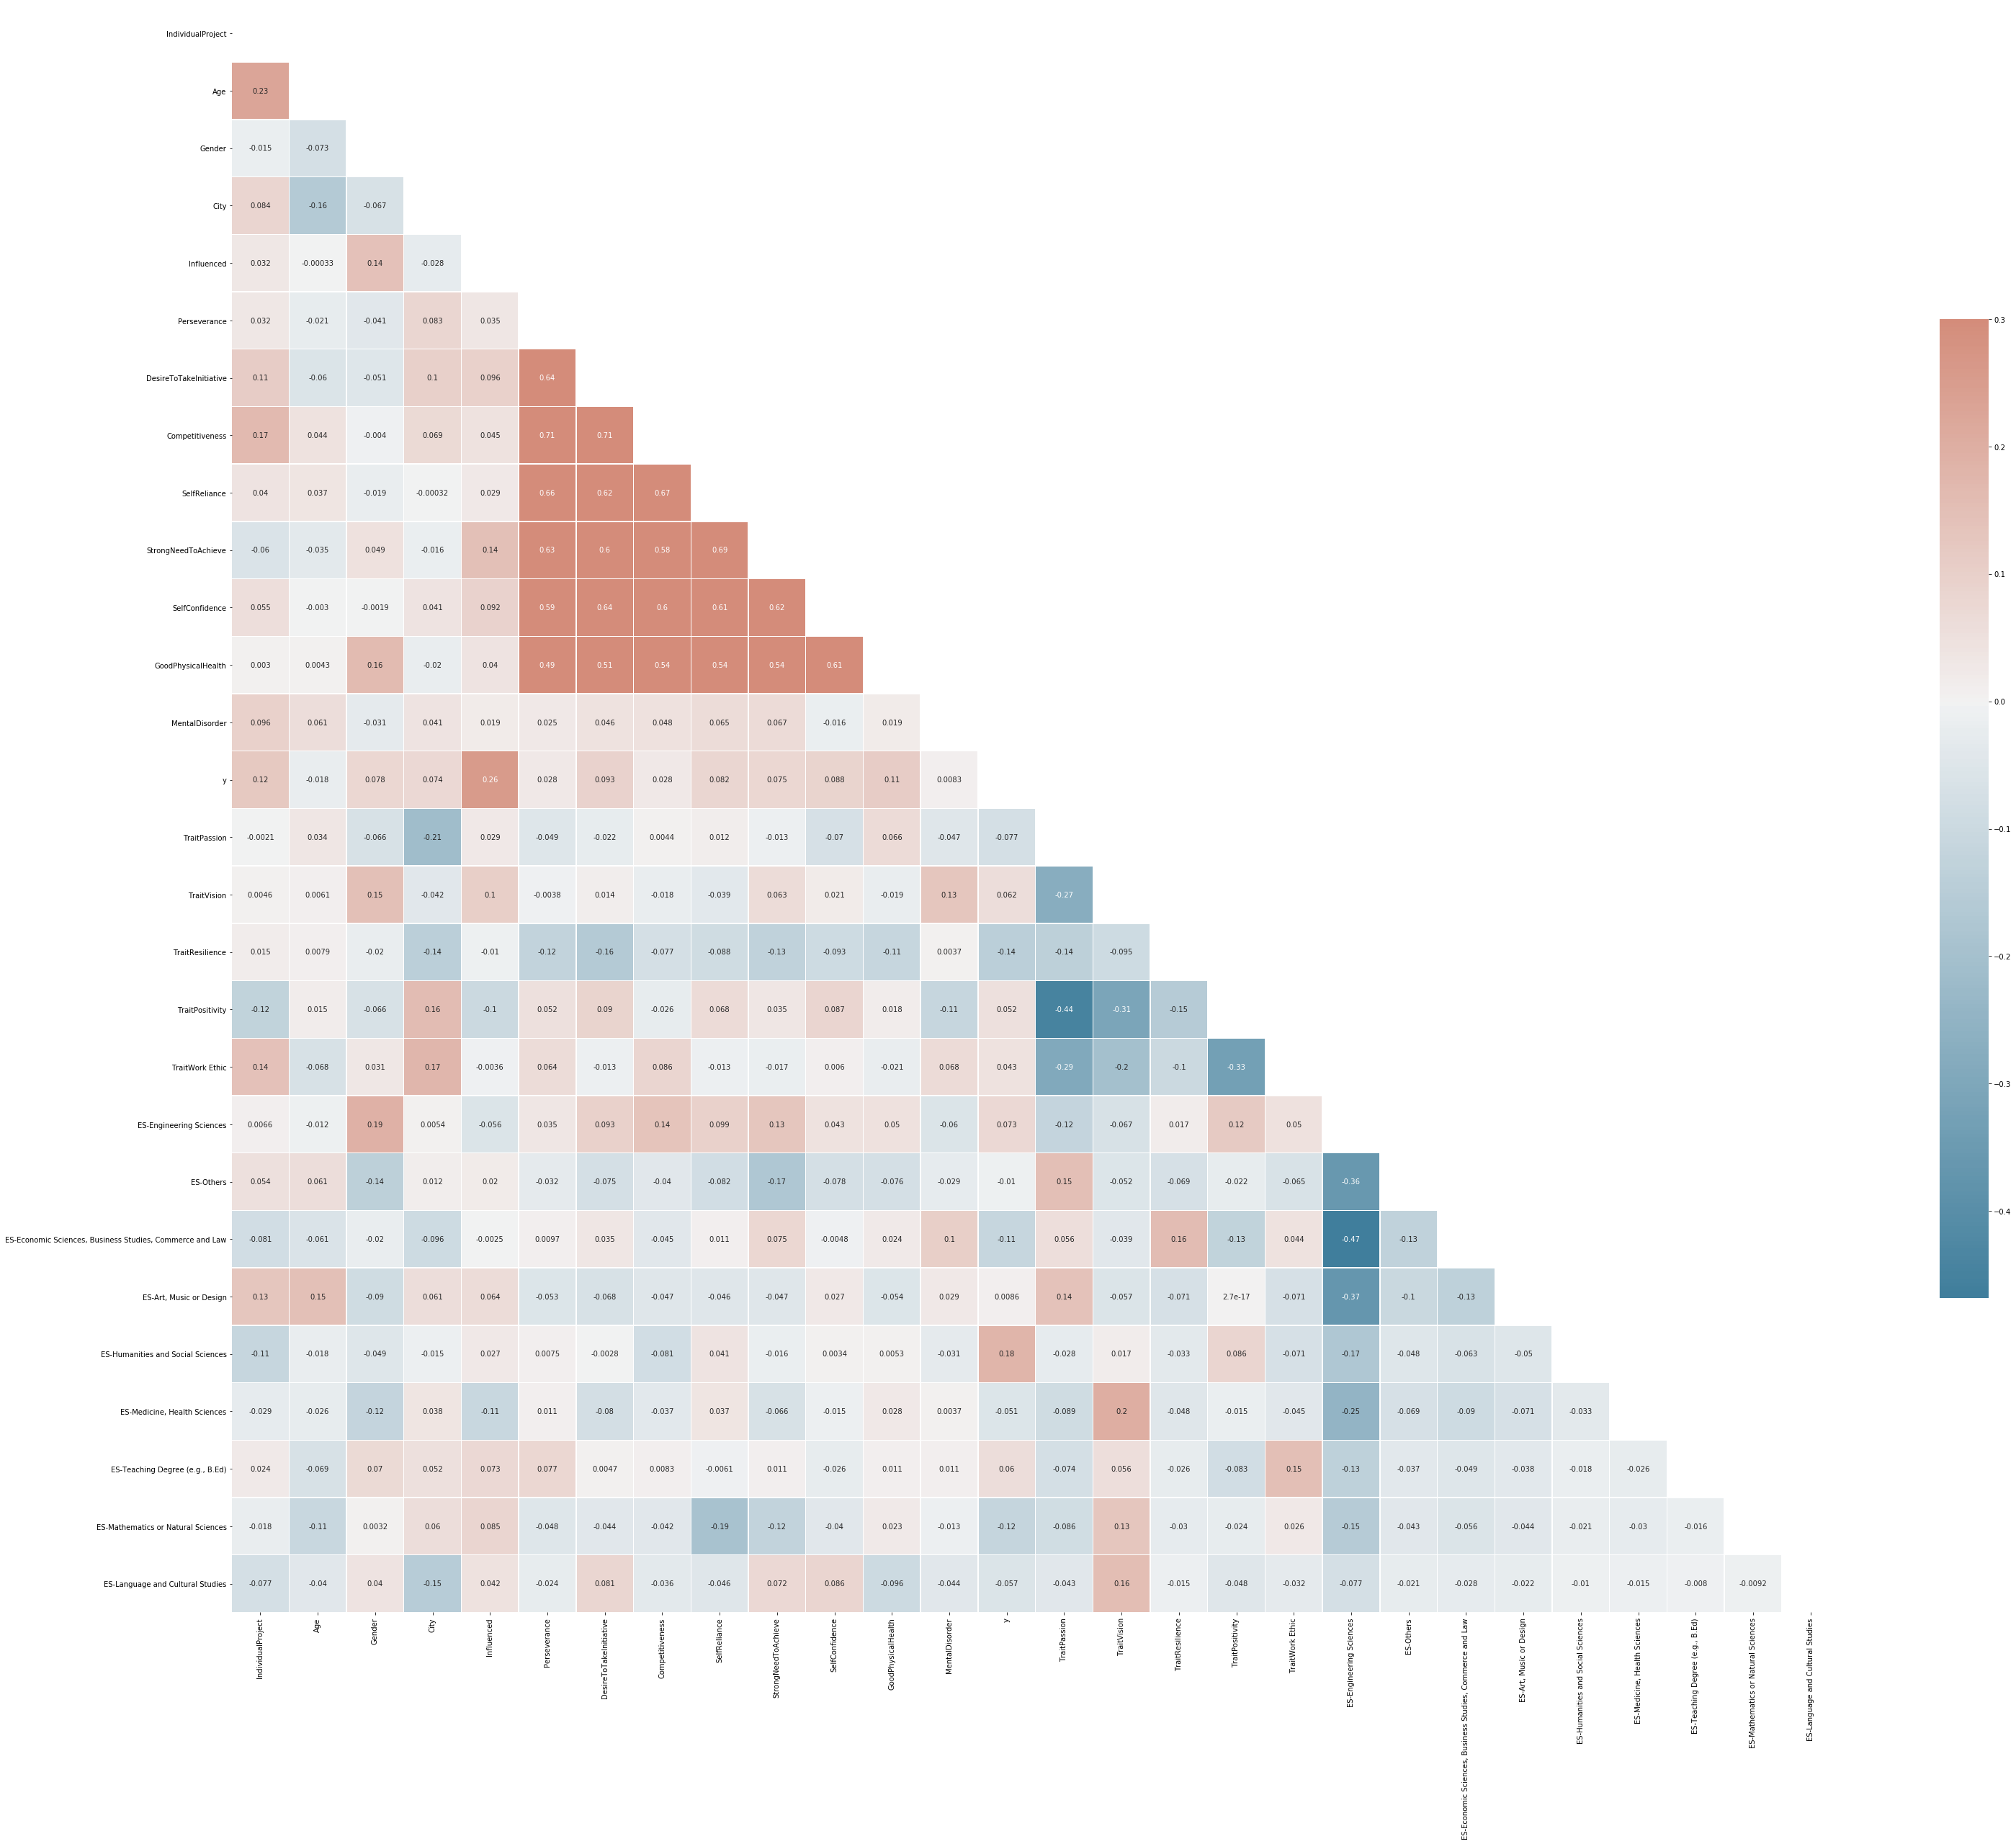

In [4]:
df.drop(columns=['ReasonsForLack'], inplace=True)

data = df.copy()
ind_map = {'Yes':1, 'No':0}
data['IndividualProject'] = data['IndividualProject'].map(ind_map)

gen_map = {'Male':1, 'Female':0}
data['Gender'] = data['Gender'].map(gen_map)

cit_map = {'Yes':1, 'No':0}
data['City'] = data['City'].map(cit_map)

inf_map = {'Yes':1, 'No':0}
data['Influenced'] = data['Influenced'].map(inf_map)

men_map = {'Yes':1, 'No':0}
data['MentalDisorder'] = data['MentalDisorder'].map(men_map)

for t in data['KeyTraits'].unique():
    data[f'Trait{t}'] = data['KeyTraits'] == t
    
for e in data['EducationSector'].unique():
    data[f'ES-{e}'] = data['EducationSector'] == e

    
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

Thanks to the correlation map we can select features that contribute the most to the outcome:
* Age
* Individual Project
* Gender
* City
* Influenced
* SelfConfidence
* Strong Need To Achieve
* Good Physical Health

### Interesting variables inspection

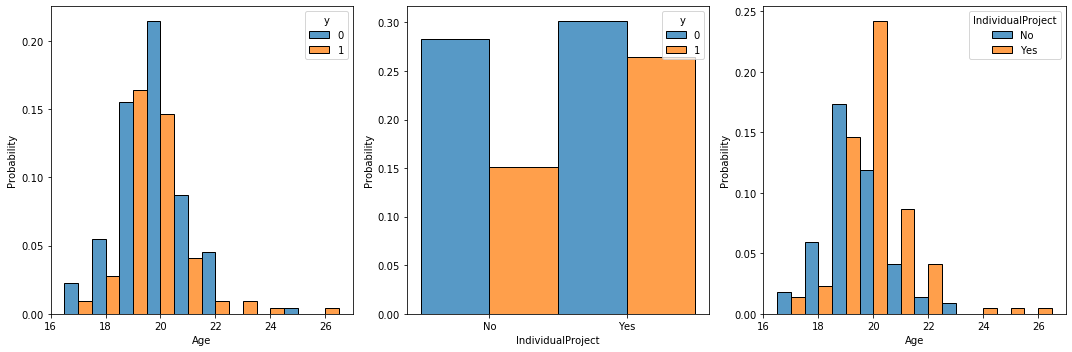

In [5]:
fig, (a1, a2, a3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(x=df['Age'], hue='y', data=df, discrete=True, stat='probability', multiple="dodge", ax=a1)
sns.histplot(x=df['IndividualProject'], hue='y', data=df, discrete=True, stat='probability', multiple="dodge", ax=a2)
sns.histplot(x=df['Age'], hue='IndividualProject', data=df, discrete=True, stat='probability', multiple="dodge", ax=a3)
a2.set_xticks([0, 1])
fig.tight_layout()

From the above plots, we can see that students that have an individual project and aged 19-20 have the highest chance at becoming entrepreneurs.

Moreover, there is a moderate positive correlation between *Age* and *IndividualProject* and by inspecting the two variables, students have an individual project at the same age that they are more probable to become entrepreneurs. This might be due to the fact that students at that age just finished school and with their individual project start a company.

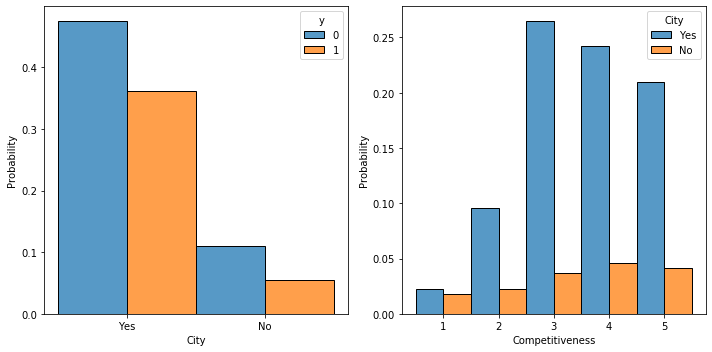

In [6]:
fig, (a1, a2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.histplot(x=df['City'], hue='y', data=df, discrete=True, stat='probability', multiple="dodge", ax=a1)
sns.histplot(x=df['Competitiveness'], hue='City', data=df, discrete=True, stat='probability', multiple="dodge", ax=a2)

fig.tight_layout()

Students from a city are more likely to become entrepreneurs, as there's higher population in cities which leads to students growing up in cities being more competitive and the second plot confirms it.

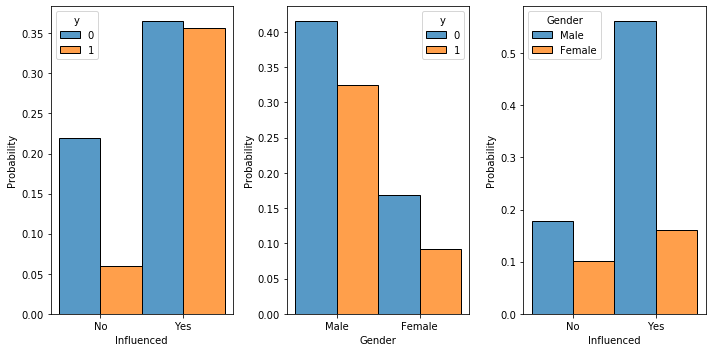

In [7]:
fig, (a1, a2, a3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

sns.histplot(x=df['Influenced'], hue='y', data=df, discrete=True, stat='probability', multiple="dodge", ax=a1)
sns.histplot(x=df['Gender'], hue='y', data=df, discrete=True, stat='probability', multiple="dodge", ax=a2)
sns.histplot(x=df['Influenced'], hue='Gender', data=df, discrete=True, stat='probability', multiple="dodge", ax=a3)

fig.tight_layout()

Being influenced by someone plays a significant role in being a successful entrepreneur.

It appears that men (1) are more likely to become entrepreneurs which is representative of most first world countries. It's likely that women aren't provided with as much family support, or perhaps don't have the same opportunities or have less interest in pursuing a career in this field. 

Also men are more influenced, as they are probably inspired by other successful male entrepreneurs while the same might not apply to women that have much fewer representatives in this field.


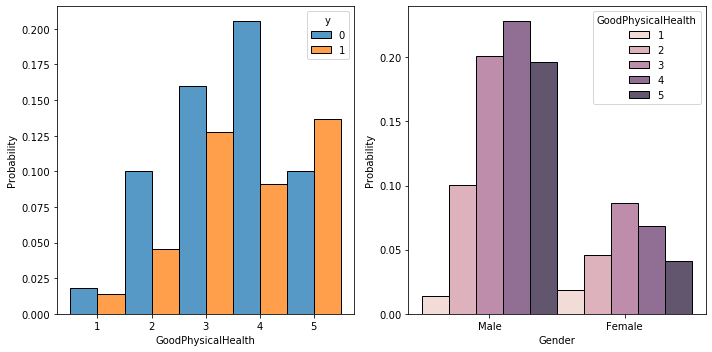

In [8]:
fig, (a1, a2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.histplot(x=df['GoodPhysicalHealth'], hue='y', data=df, discrete=True, stat='probability', multiple="dodge", ax=a1)
sns.histplot(x=df['Gender'], hue='GoodPhysicalHealth', data=df, discrete=True, stat='probability', multiple="dodge", ax=a2)

fig.tight_layout()

Students with GoodPhysicalHealth greater than 3 are more likely to be entreprenurially competent as a better physical health probably allows one to handle stress a lot better than those with poor physical health.

Moreover, by inspecting the probability of GoodPhysicalHealth of the two genders we can see that men tend to have a better physical health with respect to women.

After this analysis, we can drop other unuseful columns like *KeyTraits* and *EducationSector* and split the dataset 80% for traning and 20% for testing.

In [9]:
df.drop(columns=['KeyTraits', 'EducationSector'], inplace=True)

In [10]:
np.random.seed(50)
sample = np.random.choice(df.index, size=int(len(df) * 0.8), replace=False)

train_data = df.iloc[sample]
test_data = df.drop(sample)
test_y = test_data['y']
test_data.drop(columns=['y'], inplace=True)

### My custom model

From the previous analysis, I defined the following network structure.

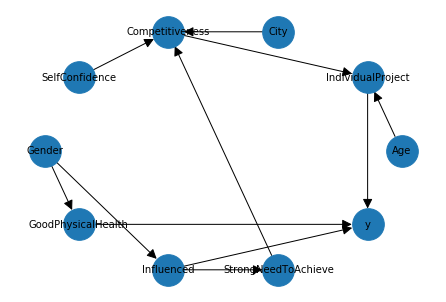

In [11]:
from pgmpy.models import BayesianModel

import networkx as nx

# Defining the network structure
custom_student_model = BayesianModel([('Age','IndividualProject'),
                                      ('City','Competitiveness'),
                                      ('SelfConfidence','Competitiveness'),
                                      ('Competitiveness', 'IndividualProject'),
                                      ('Gender','GoodPhysicalHealth'),
                                      ('Gender','Influenced'),
                                      ('Influenced', 'StrongNeedToAchieve'),
                                      ('StrongNeedToAchieve','Competitiveness'),
                                      ('Influenced', 'y'), 
                                      ('GoodPhysicalHealth', 'y'), 
                                      ('IndividualProject', 'y')])

nx.draw_circular(custom_student_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

I'm also interested in having a simpler model and see how well it performs.

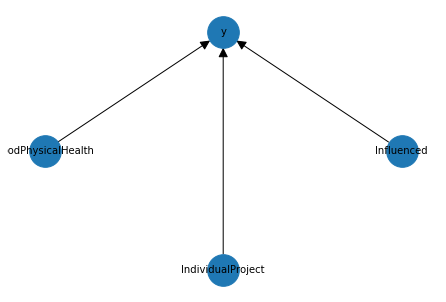

In [12]:
custom_simple_model = BayesianModel([('Influenced', 'y'),
                                     ('GoodPhysicalHealth', 'y'),
                                     ('IndividualProject', 'y')])

nx.draw_circular(custom_simple_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

## Structure Learning

### Score-based Structure Learning

Given a data T = {y1, . . . ,yN} and a scoring function φ, the problem of learning a Bayesian network is to find a Bayesian network B ∈ Bn that maximizes the value φ(B, T).

The **hill-climbing search** algorithm is a very basic local search algorithm. It is simply a loop that continually moves in the direction of increasing value (uphill) - in other words, it performs a move only if the resulting solution is better than the current one. It terminates when no neighbor has an higher value than the current solution (i.e. when it finds a local optimum). 

The **HillClimbSearch** class of pgmpy performs local hill climb search to estimates the DAG structure that has optimal score, according to the scoring method supplied. Starts at model *start_dag* and proceeds by step-by-step network modifications until a local maximum is reached. 

I used **BDeuScore** and **K2Score** as scoring functions to generate two different models through hill-climb search.

In order to guide the searching algorithm I tested some parameters in HillClimbSearch like *fixed_edges* and *black_list*.

* *fixed_edges*: from the above analysis of the correlation matrix we can see that there are 3 columns that influence the most the target: *GoodPhysicalHealth*, *Influenced* and *IndividualProject*. When I didn't impose edges from these 3 variables to the target, it appened that the algorithm assigned edges from the taget to the variables and this is not correct as we don't want outcoming edges from the taget.
      

* *black_list*: in this dataset we have 3 variables that we can assume to be independent: *Age*, *Gender* and *City*. In order to avoid incoming edges from other variables to these independent ones, I listed all possible incoming edges and excluded them from the search by passing the list to the *black_list* parameter.

In [13]:
fixed = [('GoodPhysicalHealth', 'y'), ('Influenced', 'y'), ('IndividualProject', 'y')]
no_edges = list(set().union(*[[(c, i) for c in train_data.columns if c != i] for i in ['Age', 'City', 'Gender']]))

  0%|          | 8/1000000 [00:04<148:29:51,  1.87it/s]


Hill Climb Search with BDeu Score


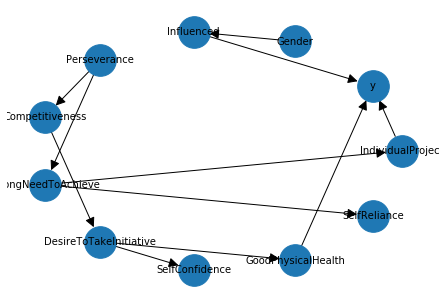

In [14]:
from pgmpy.estimators import HillClimbSearch, BDeuScore, K2Score

hc = HillClimbSearch(train_data)
hc_bds_model = BayesianModel(
    hc.estimate(
        scoring_method=BDeuScore(train_data), 
        fixed_edges=fixed,
        black_list=no_edges
    )
    .edges())
print('Hill Climb Search with BDeu Score')
nx.draw_circular(hc_bds_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

  0%|          | 13/1000000 [00:04<106:49:12,  2.60it/s]


Hill Climb Search with K2 Score


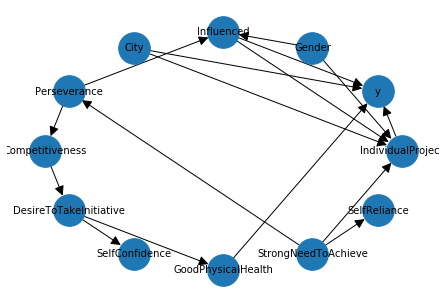

In [15]:
hc = HillClimbSearch(train_data)
hc_k2s_model = BayesianModel(
    hc.estimate(
        scoring_method=K2Score(train_data),
        fixed_edges=fixed,
        black_list=no_edges
    )
    .edges())
print('Hill Climb Search with K2 Score')
nx.draw_circular(hc_k2s_model, with_labels=True, arrowsize=20, node_size=1000, font_size=10)
plt.show()

### Parameter Estimation

The **Maximum Likelihood** estimator tries to fill the CDPs in such a way that $P(\text{data}|\text{model})$ is maximal. This is achieved when using the relative frequencies. While very straightforward, this estimator has the problem of overfitting to the data and moreover, if the observed data is not representative for the underlying distribution, Maximum Likelihood estimations will be extremly far off.

The **Bayesian** estimator starts with already existing prior CPDs, that express the beliefs about the variables before the data are observed. Those "priors" are then updated, using the state counts from the observed data. A very simple prior is the **K2** prior, which simply adds 1 to the count of every single state. A somewhat more sensible choice of prior is **BDeu** (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration).

I tested both the **Maximum Likelihood** estimator and the **Bayesian** estimator and then choose the one that performs better.

In [16]:
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

def estimate_parameters(models, data):
    ''' 
    Given a list of models and the data
    uses MLE and Bayesian estimator to
    return a dictionary model -> pairs of cdps
    '''
    fitted = {}
    for name, model in models.items():
        mle = model.copy()
        mle.fit(data, estimator=MaximumLikelihoodEstimator)
        bay = model.copy()
        bay.fit(data, estimator=BayesianEstimator, prior_type='BDeu', equivalent_sample_size=5)
        fitted[name] = (mle, bay)
    return fitted

In [17]:
models = {'Custom': custom_student_model, 
          'SimpleCustom': custom_simple_model, 
          'HillClimbSearch-BDeuScore': hc_bds_model, 
          'HillClimbSearch-K2Score': hc_k2s_model}

fitted_models = estimate_parameters(models, train_data)

## Prediction

The *predict* method of the class BayesianModel recives in input a dataframe with missing values and predicts them using **VariableElimination**, in particular it chooses the states with the highest probability value conditioned on the evidence (input data).


In [18]:
import numpy as np

def accuracy_score(y_true, y_pred):
    correct = (np.array(y_pred) == np.array(y_true)).sum()
    acc = correct/len(y_pred)
    return acc, correct

for name, (mle, bay) in fitted_models.items():
    columns = list(mle.nodes)
    columns.remove('y')
    
    y_pred = mle.predict(test_data[columns])['y']
    print(f'Maximum Likelihood estimator with model {name}')
    acc, corr = accuracy_score(test_y, y_pred)
    print(f'Accuracy: {acc:.2f} ({corr}/{len(test_data)})')
    
    y_pred = bay.predict(test_data[columns])['y']
    print(f'Bayesian estimator with model {name}')
    acc, corr = accuracy_score(test_y, y_pred)
    print(f'Accuracy: {acc:.2f} ({corr}/{len(test_data)})')


  0%|          | 0/43 [00:00<?, ?it/s]

Maximum Likelihood estimator with model Custom
Accuracy: 0.64 (28/44)


100%|██████████| 16/16 [00:00<00:00, 124.59it/s]

Bayesian estimator with model Custom
Accuracy: 0.64 (28/44)



100%|██████████| 16/16 [00:00<00:00, 113.75it/s]


Maximum Likelihood estimator with model SimpleCustom
Accuracy: 0.64 (28/44)


  0%|          | 0/43 [00:00<?, ?it/s]

Bayesian estimator with model SimpleCustom
Accuracy: 0.64 (28/44)


  0%|          | 0/43 [00:00<?, ?it/s]

Maximum Likelihood estimator with model HillClimbSearch-BDeuScore
Accuracy: 0.64 (28/44)


  0%|          | 0/44 [00:00<?, ?it/s]

Bayesian estimator with model HillClimbSearch-BDeuScore
Accuracy: 0.64 (28/44)


  0%|          | 0/44 [00:00<?, ?it/s]

Maximum Likelihood estimator with model HillClimbSearch-K2Score
Accuracy: 0.66 (29/44)


100%|██████████| 44/44 [00:02<00:00, 21.26it/s]


Bayesian estimator with model HillClimbSearch-K2Score
Accuracy: 0.66 (29/44)
